## 特徵點匹配（Feature-based Matching）
在OpenCV中，基於特徵的匹配（Feature-based Matching）是一種常見的影像比對方法，它通常用於尋找影像中相似的特徵點，然後利用這些特徵點進行匹配。以下是一些在OpenCV中常見的基於特徵的匹配方法：

- SIFT（尺度不變特徵變換）：SIFT是一種基於影像局部特徵的描述子，它對於尺度、旋轉和亮度的變化具有不變性，因此在很多場景中都有較好的效果。
- SURF（加速穩健特徵）：SURF是一種類似於SIFT的特徵描述子，但在計算上更加高效，因此在實時應用中更受歡迎。
- ORB（Oriented FAST and Rotated BRIEF）：ORB是一種融合了FAST特徵檢測器和BRIEF描述子的特徵方法，它具有快速和穩定的特點，尤其適合在資源受限的情況下使用。
- KAZE和AKAZE：這兩種方法是基於梯度信息的特徵描述子，KAZE對影像的旋轉、縮放和亮度變化具有不變性，而AKAZE在速度和記憶體占用方面更加優秀。
- FLANN（快速最近鄰搜索庫）：FLANN是一個快速的最近鄰搜索庫，常用於在大數據集中進行特徵匹配。

/var/folders/zl/457gnmjx74z81t9knnglchvm0000gn/T/ipykernel_74679/2358182051.py:47: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  img = cv2.line(img_scene.copy(), tuple(np.int0(dst[1][0])), tuple(np.int0(dst[2][0])), (0, 0, 255), 5)


109.1209015747992


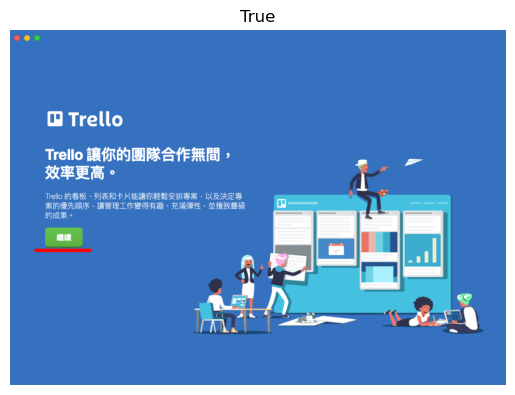

In [1]:
# pip install opencv-contrib-python
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

def find_SIFT(img_scene, img_object):
    MIN_MATCH_COUNT = 9
    matchesMask = False
    gray_img = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY) # 模板圖像(比對項目)
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img_object,None)
    kp2, des2 = sift.detectAndCompute(gray_img,None)
    # 判斷特徵點數小於10就不計算，回傳原圖
    # if(len(kp2)<10):
    #     continue

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts.astype(np.float32), dst_pts.astype(np.float32), cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img_object.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        # check empty error
        if M is None:
            print('Empty!')
        dst = cv2.perspectiveTransform(pts,M)

#             img = cv2.polylines(img_scene,[np.int32(dst)],True,(0, 0, 255),1, cv2.LINE_AA)
        img = cv2.line(img_scene.copy(), tuple(np.int0(dst[1][0])), tuple(np.int0(dst[2][0])), (0, 0, 255), 5)
        line_dist = math.sqrt( ((dst[1][0][0]-dst[2][0][0])**2)+((dst[1][0][1]-dst[2][0][1])**2) )
        print(line_dist)
        matchesMask = True
    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    if matchesMask==True:
        return img, 'True'
    else:
        return img_scene, 'False'

img_scene = cv2.imread('./example/demo1.png')
img_object = cv2.imread('./example/demo1-1.png',0)
img_SIFT, check = find_SIFT(img_scene, img_object)
plt.title(check)
plt.imshow(img_SIFT[:,:,::-1])
plt.axis('off')
plt.show()# pip install opencv-contrib-python

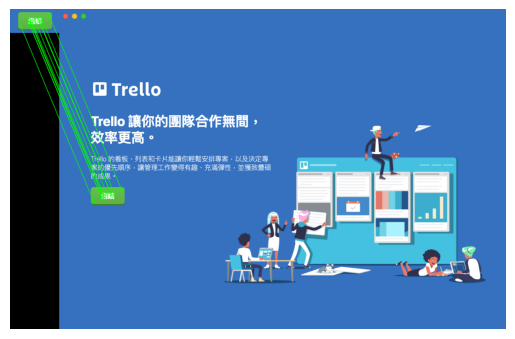

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
 
MIN_MATCH_COUNT = 10

# 原始圖像
img_scene = cv2.imread('./example/demo1.png')
# 模板圖像(比對項目)
img_object = cv2.imread('./example/demo1-1.png')
img1 = cv2.cvtColor(img_object.copy(), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img_scene.copy(), cv2.COLOR_BGR2GRAY)
 
# Initiate SIFT detector
sift = cv2.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
 
flann = cv2.FlannBasedMatcher(index_params, search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
 if m.distance < 0.7*n.distance:
    good.append(m)

if len(good)>MIN_MATCH_COUNT:
 src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
 dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
 M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
 matchesMask = mask.ravel().tolist()
 
 h,w = img1.shape
 pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
 dst = cv2.perspectiveTransform(pts,M)
 
 img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
 
else:
 print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
 matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
 singlePointColor = None,
 matchesMask = matchesMask, # draw only inliers
 flags = 2)
 
img3 = cv2.drawMatches(img_object,kp1,img_scene,kp2,good,None,**draw_params)
 
plt.imshow(img3[:, :, ::-1])
plt.axis('off')
plt.show()